In [1]:
import importlib
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pkg import plot_twin_lines
import os
os.chdir("/Users/caropark/FAO_ag_check_code/")
plt.rcParams.update({'font.size': 22})

In [2]:
combined = pd.read_csv("./data/yield_comparison.csv")

maize_18 = (combined.query("cropname == 'Maize' and `yield_log_dt` == `yield_log_dt`") 
    .assign(counts=lambda d: d.groupby('iso_a3')['iso_a3'].transform('size'))
    .query("counts > 17")
    .copy()
    .rename(columns={"year": 'Year'}))

corrdf = maize_18.groupby(['country', 'iso_a3']).apply(lambda d:pd.Series(stats.pearsonr(d['csif_log_dt'], d['yield_log_dt']),
                                                                           index=["corr", "pval"])).reset_index()
corrdf = corrdf.assign(pval= lambda d: round(d['pval'], 4),
                       **{"abs(corr)": lambda d: abs(d['corr'])})

#corr_idx = corrdf.sort_values("abs(corr)").reset_index()[['country', 'iso_a3']]
corr_idx = corrdf.sort_values("corr").reset_index()[['country', 'iso_a3']]

flags = (pd.read_csv("./data/faostat_all_flags.csv")[lambda df: df['Flag Description'] == "Estimated value"]
       .query("cropname == 'Maize' "))[['iso_a3', 'country', 'Year', 'cropname']].rename({"Year":"year"}, axis=1).drop_duplicates()
flags['flag'] = pd.to_numeric(1)


# clean from here

In [3]:
# def pearson_corr(df: pd.DataFrame, x: str, y: str) -> float:
#     sub = df[[x, y]].dropna()
#     if len(sub) < 2:
#         return np.nan
#     return sub.corr().iloc[0, 1] ## off-diagonal = correlation

# def annotate_corr(data, color, **kws):
#     ax = plt.gca()
#     sub_df = data[['csif', 'yield']].dropna()
#     if len(sub_df) >= 2:
#         r, _ = stats.pearsonr(sub_df['csif'], sub_df['yield'])
#         ax.annotate(f"r = {r:.2f}",
#             xy=(0.08, 0.90), xycoords=ax.transAxes,
#             bbox=dict(boxstyle='round,pad=0.3', edgecolor='none', facecolor='lightyellow'))

# def plot_yield_secondary(data, **kws):
#     data.columns = data.columns.str.lower()
#     ax1 = plt.gca()
#     ax2 = ax1.twinx()
#     sns.lineplot(data=data, x="year", y="yield", ax=ax2, lw=2, ci=None, color="black")
#     ax2.set_ylabel("")  
#     if data['year'].notna().any():
#         xmin, xmax = np.nanmin(data['year']), np.nanmax(data['year'])
#         ax1.set_xlim(xmin, xmax)
#         xticks = np.linspace(round(xmin), round(xmax), num=3, dtype=int)
#         ax1.set_xticks(xticks)
#         ax1.set_xticklabels([str(t) for t in xticks])

# def plot_master(data, col, col_order, col_wrap, grid_kwargs, plot_kwargs):
#     data.columns = data.columns.str.lower()

#     grid_args = dict(data=data, col=col, 
#         col_order=col_order, col_wrap=col_wrap,
#         height=4, aspect=1.4,
#         sharey=False,despine=False)
#     if grid_kwargs:
#         grid_args.update(grid_kwargs)

#     g = sns.FacetGrid(**grid_args)

#     plot_args = dict(x="year", y="csif", lw=3, ci=None)
#     if plot_kwargs:
#         plot_args.update(plot_kwargs)

#     g.map_dataframe(sns.lineplot, **plot_args)

#     for ax in g.axes.flat:
#         ax.tick_params(axis='y', colors='red')
#         ax.set_ylabel("", color='red')

#     g.map_dataframe(annotate_corr)
#     g.map_dataframe(plot_yield_secondary)
#     g.set_axis_labels("", "")
#     g.set_titles(col_template="{col_name}", size=18)

#     g.fig.text(0.5, 0.035, 'Year', ha='center', va='center')
#     g.fig.text(0.03, 0.5, 'Satellite-derived yields (log, dt)', ha='center', va='center',
#             rotation='vertical', color="red")
#     g.fig.text(0.985, 0.5, 'Survey-derived yields (log, dt)', ha='center', va='center',
#             rotation='-90')

#     g.fig.tight_layout(rect=[0.05, 0.06, 0.96, 0.97])
#     plt.show()

True


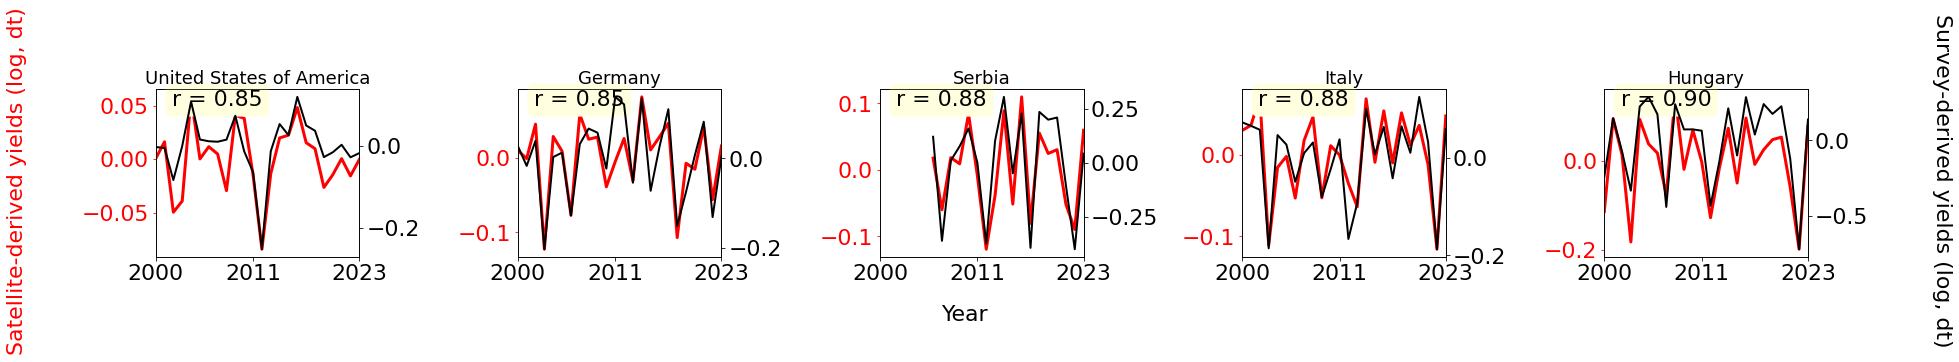

In [4]:
df = maize_18[maize_18['iso_a3'].isin(corr_idx.iloc[-5:,1])]
flags_best = flags[flags['iso_a3'].isin(corr_idx.iloc[-5:,1])]
print(flags_best.empty)

plot_twin_lines(df, col="country", col_wrap = 5, col_order = corr_idx.iloc[-5:,0], grid_kwargs=None, plot_kwargs={'color': "red"}, filename="global_maize_best_ts.pdf")

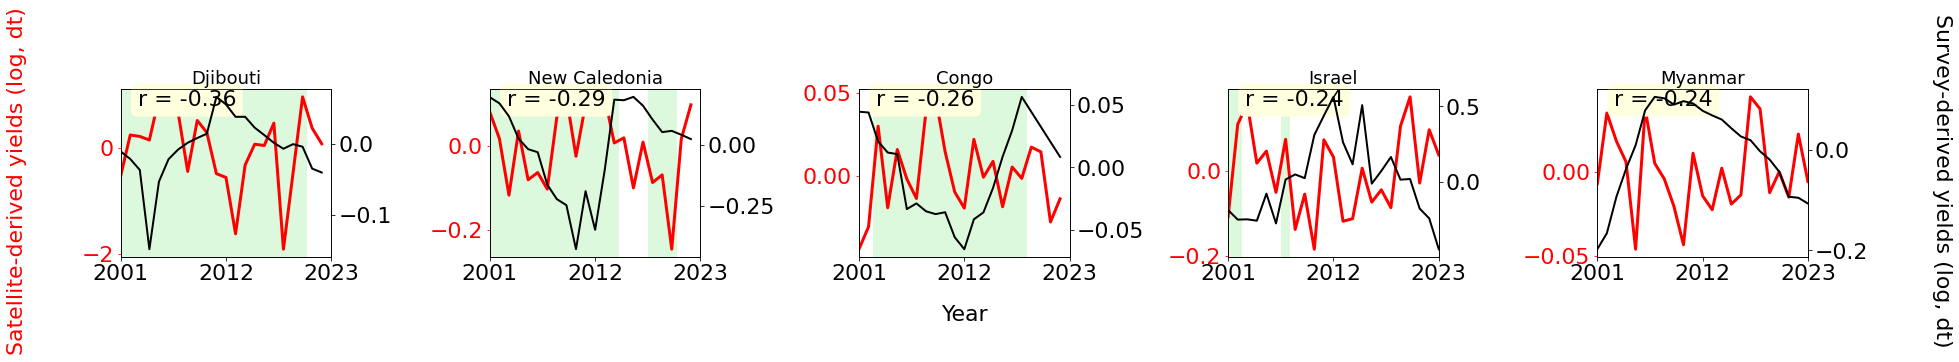

In [5]:
df = maize_18[maize_18['country'].isin(corr_idx.iloc[:5,0])]
flags_worst = flags[flags["iso_a3"].isin(corr_idx.iloc[:5,1])]
flags_worst.groupby('iso_a3')[['year']].agg([min, max, len])
fl = flags_worst[["country", 'year']].values.tolist()

plot_twin_lines(df, col="country", col_wrap = 5, col_order = corr_idx.iloc[:5,0], grid_kwargs=None, plot_kwargs={'color': "red"}, 
                filename="global_maize_worst_ts.pdf", fl=fl)
